In [ ]:
#imports
import os
import numpy as np
import pandas as pd 
from PIL import Image
from PIL import ImageChops
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import statistics
from matplotlib import pyplot as plt
import natsort
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#connecting to drive
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/pattern/kaggle_dataset'


Mounted at /content/gdrive


## **Data Preparation**

In [ ]:
# prepare data
image_label= 0

labels = []
data_matrix = np.empty((0,10304),int)
print(data_matrix)
for root, dirs, files in sorted(os.walk(data_path)):
        #loop through each subject directory
        for subdir in sorted(dirs):
            #accessing each image folder
            subdir_path = os.path.join(root , subdir)
            # print("folder file ",subdir[1:], int(subdir[1:]))
            image_label=int(subdir[1:])
            for file in sorted(os.listdir(subdir_path)):
                # print("image file ",os.path.join(subdir_path , file))
                img = Image.open(os.path.join(subdir_path , file)).convert('L') 
                 # get a 1D array of pixels
                image_vector=np.asarray(img).ravel()
                # print("image vector ",image_vector)
                data_matrix=np.append(data_matrix, np.array([image_vector]), axis=0)
                labels.append(image_label)

            # image_label += 1


print (len(labels))
print(data_matrix[0])
print(data_matrix.shape)

print(data_matrix)
print(labels)

[]
400
[48 49 45 ... 47 46 46]
(400, 10304)
[[ 48  49  45 ...  47  46  46]
 [ 34  34  33 ...  37  40  33]
 [ 60  60  62 ...  32  34  34]
 ...
 [112 109 116 ...  93  88  92]
 [111 114 112 ...  88  86  92]
 [110 112 113 ...  92  87  90]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27,

## **Data Splitting**

In [ ]:
# split data
def split_data(labels,data_matrix):
  labels_train= []
  labels_test = []
  faces_train = np.empty((0,10304),int)
  faces_test = np.empty((0,10304),int)

  mixed_data_iterator = zip(labels, data_matrix)

  split = 0;
  for label, img in mixed_data_iterator:
      if split % 2 == 0:
        labels_test.append(label)
        faces_test=np.append(faces_test, np.array([img]), axis=0)

      else:
        labels_train.append(label)
        faces_train=np.append(faces_train, np.array([img]), axis=0)

      split += 1
  print ("faces train size :",faces_train.shape)
  print ("faces test size :",faces_test.shape)
  print ("label train size :",len(labels_train))
  print ("label test size :",len(labels_test))
  return labels_train,labels_test,faces_train,faces_test


In [ ]:
labels_train,labels_test,faces_train,faces_test=split_data(labels,data_matrix)

faces train size : (200, 10304)
faces test size : (200, 10304)
label train size : 200
label test size : 200


## **BONUS Data Splitting 70% training 30% testing**

In [ ]:
#split data for bonus
labels_train_set= []
labels_test_set = []
faces_train_set = np.empty((0,10304),int)
faces_test_set = np.empty((0,10304),int)

mixed_data_iterator = zip(labels, data_matrix)

step = 0;
for label, img in mixed_data_iterator:
    if step <7 :
      labels_train_set.append(label)
      faces_train_set=np.append(faces_train_set, np.array([img]), axis=0)

    else:
      labels_test_set.append(label)
      faces_test_set=np.append(faces_test_set, np.array([img]), axis=0)

    step+=1

    if step==10 :
      step=0


print ("faces train size :",faces_train_set.shape)
print ("faces test size :",faces_test_set.shape)
print ("label train size :",len(labels_train_set))
print ("label test size :",len(labels_test_set))

faces train size : (280, 10304)
faces test size : (120, 10304)
label train size : 280
label test size : 120


# **Principal Component Analysis PCA**

**eigh guarantees you that the eigenvalues are sorted and uses a faster algorithm that takes advantage of the fact that the matrix is symmetric. If you know that your matrix is symmetric, use this function.**

In [ ]:
def get_Eigens(faces_train) :
  
    #Compute Means
    Means = np.mean(faces_train,axis=0)
    #print("Means : ",Means)

    #Center the data around Origin
    Z = faces_train - Means
    #print("\nZ : ",Z)

    #Compute Covariance Matrix
    cov = np.cov(np.transpose(Z))
    #cov=np.cov(faces_train,rowvar=False,bias=True)
    #print("\nCovariance Matrix : ",cov)

    #Compute eigenvalues and eigenvectors
    
    EigenValues , EigenVectors = np.linalg.eigh(cov)
    #sort descending
    index = EigenValues.argsort()[::-1]   
    EigenValues = EigenValues[index]
    EigenVectors = EigenVectors[:,index]
    # print("\nEigenValues : ",EigenValues)
    # print("\nEigenVectors : ",EigenVectors)
    return EigenValues , EigenVectors

In [ ]:

def get_Projection_Matrix(EigenValues,EigenVectors,alpha) : 
    total_sum_Evalues = np.sum(EigenValues) 
    sum=0 
    r =0
    for Evalue in EigenValues : 
          r+=1
          sum += Evalue
          ratio = sum / total_sum_Evalues
          if(ratio >= alpha) :
            break

    print("number of eigen values taken : ",r)
    U = EigenVectors[:, :r]
    #print("\nU : ", U)
    return U 

# **KNN Classification**

In [ ]:
def knn(faces_train_reduced,labels_train,faces_test_reduced,labels_test) : 
    # Tune n-estimators parameter
    # Parameter Tuning
    k_best =0;
    max_accuracy = 0;
    accuracies = []
    best_pred = []
    for k in range(1,15,2):
      knn_model = KNeighborsClassifier(n_neighbors = k)
      knn_model.fit(faces_train_reduced, labels_train)
      # Predict Output
      labels_pred = knn_model.predict(faces_test_reduced)
      accuracy = metrics.accuracy_score(labels_test, labels_pred)
      accuracies.append(accuracy)
      if max_accuracy < accuracy :
        max_accuracy = accuracy
        best_pred = labels_pred
        k_best = k

    # print(accuracies)
    # print("Best n-neighbours: ",k_best)

    # # Display the analysis of the model
    # print("K-NN Accuracy: ",max_accuracy, "\n")
    return max_accuracy, k_best, best_pred

In [ ]:
def pca(train_data,test_data,labels_train,labels_test) : 
    EigenValues,EigenVectors = get_Eigens(train_data)
    alpha = [0.8,0.85,0.9,0.95] 
    for a in alpha :
      print("Alpha = ", a)
      U=get_Projection_Matrix(EigenValues,EigenVectors,a)
      faces_train_reduced = np.dot(train_data,U)
      faces_test_reduced = np.dot(test_data,U)
      best_accuracy_pca, best_neighbor_pca, pred = knn(faces_train_reduced,labels_train,faces_test_reduced,labels_test)
      print("Best n-neighbours: ",best_neighbor_pca)
      print("K-NN Accuracy: ",best_accuracy_pca, "\n")

In [ ]:
# testing PCA 
pca(faces_train,faces_test,labels_train,labels_test)

Alpha =  0.8
number of eigen values taken :  36
Best n-neighbours:  1
K-NN Accuracy:  0.94 

Alpha =  0.85
number of eigen values taken :  52
Best n-neighbours:  1
K-NN Accuracy:  0.945 

Alpha =  0.9
number of eigen values taken :  76
Best n-neighbours:  1
K-NN Accuracy:  0.94 

Alpha =  0.95
number of eigen values taken :  117
Best n-neighbours:  1
K-NN Accuracy:  0.935 



In [ ]:
# testing PCA for bonus
pca(faces_train_set,faces_test_set,labels_train_set,labels_test_set)

Alpha =  0.8
number of eigen values taken :  38
Best n-neighbours:  1
K-NN Accuracy:  0.9666666666666667 

Alpha =  0.85
number of eigen values taken :  57
Best n-neighbours:  1
K-NN Accuracy:  0.9583333333333334 

Alpha =  0.9
number of eigen values taken :  89
Best n-neighbours:  1
K-NN Accuracy:  0.95 

Alpha =  0.95
number of eigen values taken :  145
Best n-neighbours:  1
K-NN Accuracy:  0.9416666666666667 



# **Linear Discriminant Analysis**

In [ ]:
def LDA_Eigen(num_classes, instances_per_class, faces_train):
  num_instances = np.size(faces_train, 0)


  # Data matrix is 200 x 10304 for training set and same for testing set 
  # we have 40 class number of samples in each class is 5 for training set
  # calculate the mean vector of the overall sample needs reshaping to be 10304 x 1 
  overall_mean = np.mean(faces_train, axis = 0)
  overall_mean = overall_mean.reshape(10304, 1)

  # splitting data into classes
  classes_data = []
  count = 0
  for i in range(num_classes):
    d = faces_train[count:count+instances_per_class[i]]
    classes_data.append(d)
    count += instances_per_class[i]
  
  # calculate mean for every class of the 40 class
  # classes mean array of means 10304 x 1
  classes_means = []

  for i in range(num_classes):
    mean = np.mean(classes_data[i], axis = 0)
    classes_means.append(mean.reshape(10304,1))

  # getting Sb matrix 10304 x 10304
  Sb = np.zeros((10304, 10304))
  for i in range(num_classes):
    dif = classes_means[i] - overall_mean
    Sb = np.add(Sb, np.dot(instances_per_class[i], np.dot(dif, np.transpose(dif))))


  # getting normalized matrices Zi each z is 5 x 10304
  # getting si each s is 5 x 10304
  # getting s 10304 x 10304 by summing all si 
  s = np.zeros((10304, 10304))
  for i in range(num_classes):
    z = classes_data[i] - np.transpose(classes_means[i])
    s = np.add(s, np.dot(np.transpose(z), z))

  # compute eigen values and eigen vectors
  s_inverse = np.linalg.inv(s)
  eigen_values, eigen_vectors = np.linalg.eigh(np.dot(s_inverse, Sb))

  return eigen_values, eigen_vectors

In [ ]:
def LDA_Projected(faces_train, faces_test, eigen_values, eigen_vectors, num_dominant_eigen_vectors):
  index = eigen_values.argsort()[::-1]   
  eigen_values = eigen_values[index]
  eigen_vectors = eigen_vectors[:,index]

  # projection matrix
  projection_matrix = eigen_vectors[:,:num_dominant_eigen_vectors]
  # data after projection
  projected_faces_train = np.dot(faces_train, projection_matrix)
  projected_faces_test = np.dot(faces_test, projection_matrix)

  return projected_faces_train, projected_faces_test

In [ ]:
# testing LDA accuracy
instances_per_class = np.full(40,5)
eigen_values, eigen_vectors = LDA_Eigen(40, instances_per_class, faces_train)
projected_faces_train, projected_faces_test = LDA_Projected(faces_train, faces_test, eigen_values, eigen_vectors, 39)
print(projected_faces_train.shape)
print(projected_faces_test.shape)

(200, 39)
(200, 39)


In [ ]:
best_accuracy, best_neighbor_LDA, pred = knn(projected_faces_train, labels_train, projected_faces_test, labels_test)
print("Best n-neighbours: ", best_neighbor_LDA)
print("K-NN Accuracy: ", best_accuracy, "\n")

Best n-neighbours:  1
K-NN Accuracy:  0.955 



In [ ]:
# testing LDA accuracy for bonus
print(data_matrix.shape)
instances_per_class = np.full(40,7)
eigen_values_bonus, eigen_vectors_bonus = LDA_Eigen(40, instances_per_class, faces_train_set)
projected_faces_train_bonus, projected_faces_test_bonus = LDA_Projected(faces_train_set, faces_test_set, eigen_values_bonus, eigen_vectors_bonus, 39)
print("projected_faces_train_bonus ", projected_faces_train_bonus.shape)
print("projected_faces_test_bonus ", projected_faces_test_bonus.shape)

(400, 10304)
280
projected_faces_train_bonus  (280, 39)
projected_faces_test_bonus  (120, 39)


In [ ]:
best_accuracy, best_neighbor_LDA, pred =  knn(projected_faces_train_bonus, labels_train_set, projected_faces_test_bonus, labels_test_set)
print("Best n-neighbours: ", best_neighbor_LDA)
print("K-NN Accuracy: ", best_accuracy, "\n")

[0.9666666666666667, 0.925, 0.8666666666666667, 0.825, 0.7916666666666666, 0.775, 0.725]
Best n-neighbours:  1
K-NN Accuracy:  0.9666666666666667 



# **Faces vs Non Faces**
Faces  0    -    Non Fcaes  1

In [ ]:
data_path_non_faces = '/content/gdrive/MyDrive/pattern/non_faces_dataset/natural_images'

In [ ]:
# prepare data
import cv2

data_matrix_non_faces = np.empty((0,10304),int)
print(data_matrix_non_faces)
counter=0
for root, dirs, files in sorted(os.walk(data_path_non_faces)):
        #loop through each subject directory
        for subdir in sorted(dirs):
            #accessing each image folder
            subdir_path = os.path.join(root , subdir)
            # print("folder file ",subdir)
            for file in sorted(os.listdir(subdir_path)):
                # print("image file ",os.path.join(subdir_path , file))
                img = Image.open(os.path.join(subdir_path , file)).convert('L') 
                img= img.resize((92, 112))
                 # get a 1D array of pixels
                image_vector=np.asarray(img).ravel()
                # print("image vector ",image_vector)
                # print("image size ",image_vector.shape)
                data_matrix_non_faces=np.append(data_matrix_non_faces, np.array([image_vector]), axis=0)
                counter+=1
                if counter==300 :
                  counter=0
                  break


# shuffling non faces matrix to mix all different types of non faces
print(data_matrix_non_faces[0])
print(data_matrix_non_faces.shape)
np.random.shuffle(data_matrix_non_faces)
# print(data_matrix_non_faces)

[]
[234 234 233 ... 111 115 120]
(2100, 10304)


In [ ]:
# split data
def split_mixed_data(data_matrix):
  faces_train = np.empty((0,10305),int)
  faces_test = np.empty((0,10305),int)

  split = 0;
  for img in data_matrix:
      if split % 2 == 0:
        faces_test=np.append(faces_test, np.array([img]), axis=0)

      else:
        faces_train=np.append(faces_train, np.array([img]), axis=0)

      split += 1


  return faces_train,faces_test

In [ ]:
def get_train_test(faces_data_matrix,non_faces_data_matrix,size) :  

  
  #creating labels array
  label_faces=np.full(400,0)
  label_non_faces=np.full(len(non_faces_data_matrix),1)
  
  #adding label column to marix
  faces_matrix = np.column_stack((faces_data_matrix,label_faces.T))
  non_faces_matrix = np.column_stack((non_faces_data_matrix, label_non_faces.T))

  faces_train,faces_test=split_mixed_data(faces_matrix)
  non_faces_train,non_faces_test=split_mixed_data(non_faces_matrix[:size,:])
 


  mixed_train=np.concatenate((faces_train, non_faces_train))
  mixed_test=np.concatenate((faces_test, non_faces_test))

  # np.random.shuffle(mixed_train)
  # np.random.shuffle(mixed_test)
  
  # labesls train, labels test, matrix train, matrix test
  return mixed_train[:,10304],mixed_test[:,10304],mixed_train[:,:10304],mixed_test[:,:10304]


In [ ]:
#  Getting number of Dominant Eigen vectors
def get_num_dominant_Eigen_vectors(faces_train, faces_test, labels_train, labels_test, eigen_values, eigen_vectors):
    best_num_eigen_vec = 0
    best_accuracy = 0
    accuracies = []
    num_vec = []
    best_k = 0
    bes_pred = []
    for i in range(1, 60):
      projected_faces_train, projected_faces_test = LDA_Projected(faces_train, faces_test, eigen_values, eigen_vectors, i)
      accuracy, k, pred = knn(projected_faces_train, labels_train, projected_faces_test, labels_test)
      num_vec.append(i)
      accuracies.append(accuracy)
      # print("i = ", i, " accuracy = ", accuracy)
      if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy
        best_num_eigen_vec = i
        best_pred = pred

    plt.plot(num_vec, accuracies)
    plt.xlabel("Number of vectors")
    plt.ylabel("Accuracy")
    plt.show()

    return best_num_eigen_vec, best_accuracy, best_k, best_pred

In [ ]:
# printing images
def print_images(data_images, index, title, classification):
    my_img = data_images[index]
    my_img=np.reshape(my_img,(112,92))
    plt.imshow(my_img, cmap='gray')
    plt.title(title + str(index))
    plt.show()
    print("classified as ", classification, "\n")
    plt.close()

In [ ]:
from numpy.lib.function_base import append
#  getting some of the indexes of classified and misclassified data
def classified_misclassified(data_images, true_labels, pred_labels):
  classified_counter = 0
  misclassified_counter = 0
  classification = lambda x : "Face" if (x == 0) else "Non face"
  for i in range(0, len(true_labels),5) :
    if true_labels[i] == pred_labels[i] :
        if classified_counter < 10 :
            # print classified
            classified_counter += 1
            print_images(data_images, i, "Correctly classified images  ", classification(pred_labels[i]))
    else :
        if misclassified_counter < 10 :
            # print misclassified
            misclassified_counter += 1
            print_images(data_images, i, "Misclassified images  ", classification(pred_labels[i]))

    if classified_counter == 10 & misclassified_counter == 10 :
        break
  print(classified_counter)
  print(misclassified_counter)

# **Testing accuracies vs number of Non faces Using LDA**

300


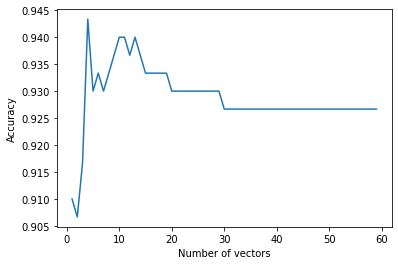

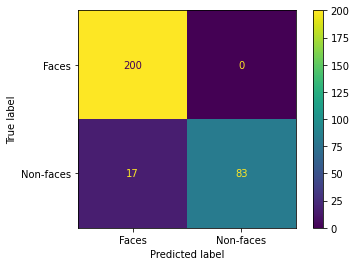


Number of eigen vectors  4
Accuracy  0.9433333333333334
neighbor   3 

400


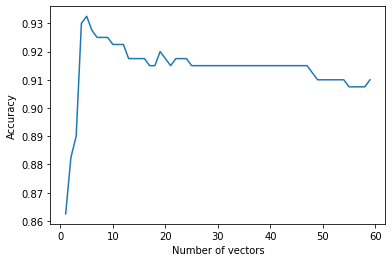

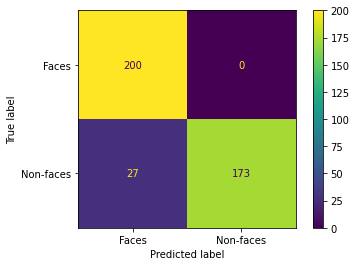


Number of eigen vectors  5
Accuracy  0.9325
neighbor   1 

500


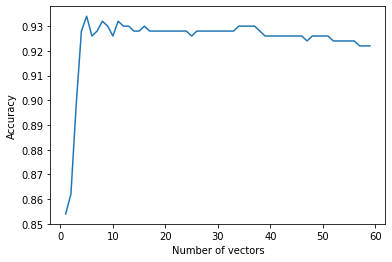

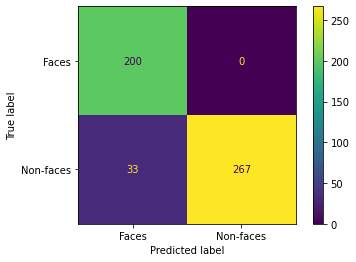


Number of eigen vectors  5
Accuracy  0.934
neighbor   1 

600


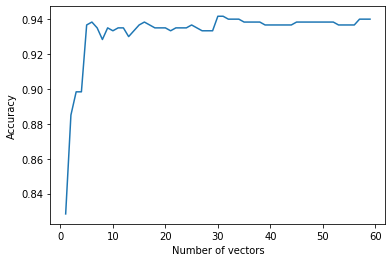

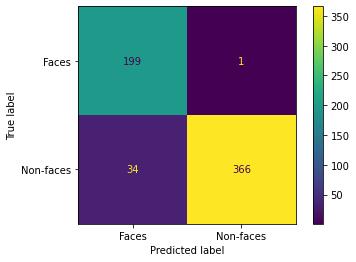


Number of eigen vectors  30
Accuracy  0.9416666666666667
neighbor   1 



In [ ]:
for i in range(200, 1000, 200):
  print("Non faces : ", i)
  labels_training, labels_testing, data_training , data_testing = get_train_test(data_matrix, data_matrix_non_faces,i)
  # getting number of eigen vectors
  instances_per_classes = np.array([200, i//2])
  # momkn a7ot el line da gowa el get num of eigen vectors bs lma at2kd anha sh8ala
  eigen_values_i, eigen_vectors_i = LDA_Eigen(2 , instances_per_classes, data_training)
  number_vectors, best_accuracy_i, best_k_i, best_pred = get_num_dominant_Eigen_vectors(data_training, data_testing, labels_training, labels_testing, eigen_values_i, eigen_vectors_i)
  confusion_matrix = metrics.confusion_matrix(labels_testing, best_pred)
  plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Faces','Non-faces'])
  plot.plot()
  plt.show()
  print("\nNumber of eigen vectors ",number_vectors)
  print("Accuracy ",best_accuracy_i)
  print("neighbor  ",best_k_i,"\n")

700


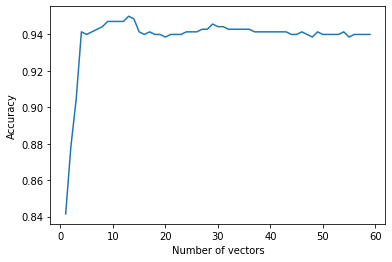

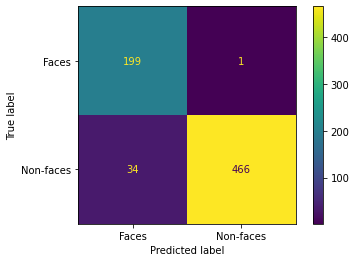

Number of eigen vectors  13
Accuracy  0.95
neighbor   1
950


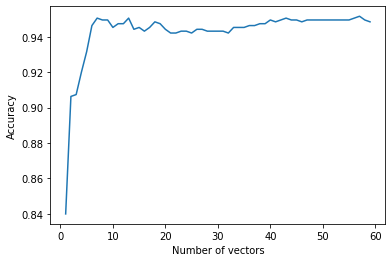

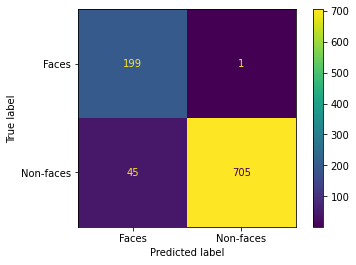

Number of eigen vectors  57
Accuracy  0.9515789473684211
neighbor   1
1200


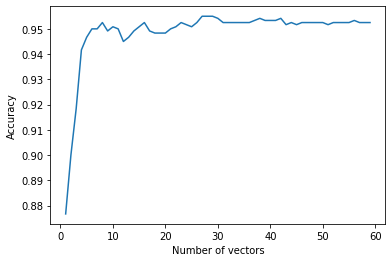

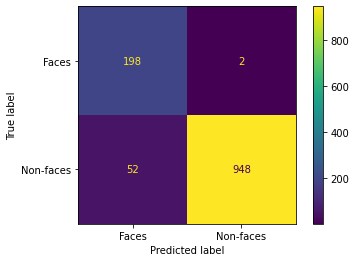

Number of eigen vectors  27
Accuracy  0.955
neighbor   1


In [ ]:
for i in range(1000, 2200, 500):
  print("Non faces : ", i)
  labels_training, labels_testing, data_training , data_testing = get_train_test(data_matrix, data_matrix_non_faces,i)
  # getting number of eigen vectors
  instances_per_classes = np.array([200, i//2])
  # momkn a7ot el line da gowa el get num of eigen vectors bs lma at2kd anha sh8ala
  eigen_values_i, eigen_vectors_i = LDA_Eigen(2 , instances_per_classes, data_training)
  number_vectors, best_accuracy_i, best_k_i, best_pred = get_num_dominant_Eigen_vectors(data_training, data_testing, labels_training, labels_testing, eigen_values_i, eigen_vectors_i)
  confusion_matrix = metrics.confusion_matrix(labels_testing, best_pred)
  plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Faces','Non-faces'])
  plot.plot()
  plt.show()
  print("Number of eigen vectors ",number_vectors)
  print("Accuracy ",best_accuracy_i)
  print("neighbor  ",best_k_i)

Non faces :  200


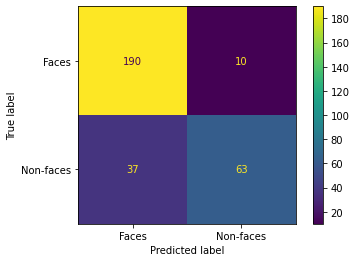

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       200
           1       0.86      0.63      0.73       100

    accuracy                           0.84       300
   macro avg       0.85      0.79      0.81       300
weighted avg       0.85      0.84      0.84       300
 

neighbor   7 

Non faces :  400


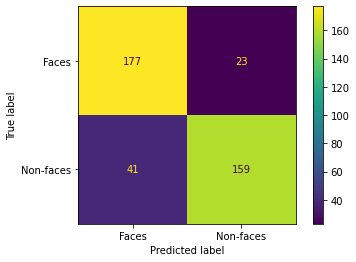

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       200
           1       0.87      0.80      0.83       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400
 

neighbor   7 

Non faces :  600


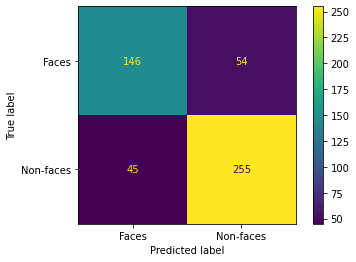

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       200
           1       0.83      0.85      0.84       300

    accuracy                           0.80       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.80      0.80      0.80       500
 

neighbor   1 

Non faces :  800


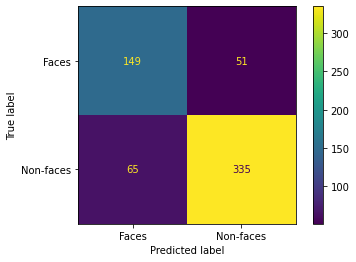

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       200
           1       0.87      0.84      0.85       400

    accuracy                           0.81       600
   macro avg       0.78      0.79      0.79       600
weighted avg       0.81      0.81      0.81       600
 

neighbor   11 



In [ ]:
for i in range(200, 1000, 200):
  print("Non faces : ", i)
  labels_training, labels_testing, data_training , data_testing = get_train_test(data_matrix, data_matrix_non_faces,i)
  # getting number of eigen vectors
  instances_per_classes = np.array([200, i//2])
  # momkn a7ot el line da gowa el get num of eigen vectors bs lma at2kd anha sh8ala
  eigen_values_i, eigen_vectors_i = LDA_Eigen(2 , instances_per_classes, data_training)
  projected_faces_train, projected_faces_test = LDA_Projected(data_training, data_testing, eigen_values_i, eigen_vectors_i, 1)
  best_accuracy_i , best_k_i, best_pred = knn(projected_faces_train, labels_training, projected_faces_test, labels_testing)
  confusion_matrix = metrics.confusion_matrix(labels_testing, best_pred)
  plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Faces','Non-faces'])
  plot.plot()
  plt.show()
  print(metrics.classification_report(labels_testing, best_pred),"\n")
  print("neighbor  ",best_k_i,"\n")

Non faces :  1000


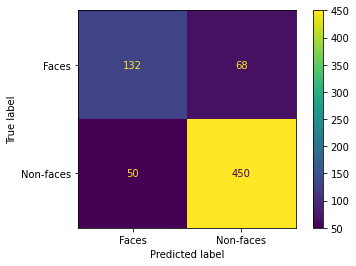

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       200
           1       0.87      0.90      0.88       500

    accuracy                           0.83       700
   macro avg       0.80      0.78      0.79       700
weighted avg       0.83      0.83      0.83       700
 

neighbor   9 

Non faces :  1200


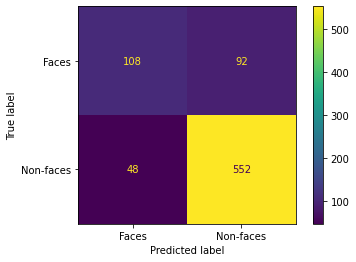

              precision    recall  f1-score   support

           0       0.69      0.54      0.61       200
           1       0.86      0.92      0.89       600

    accuracy                           0.82       800
   macro avg       0.77      0.73      0.75       800
weighted avg       0.82      0.82      0.82       800
 

neighbor   11 

Non faces :  1400


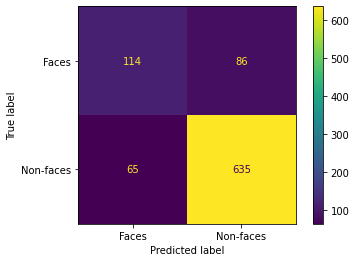

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       200
           1       0.88      0.91      0.89       700

    accuracy                           0.83       900
   macro avg       0.76      0.74      0.75       900
weighted avg       0.83      0.83      0.83       900
 

neighbor   13 

Non faces :  1600


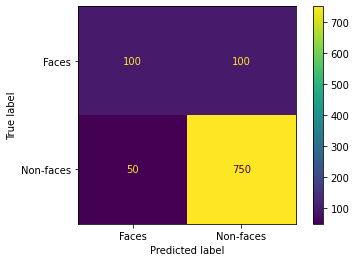

              precision    recall  f1-score   support

           0       0.67      0.50      0.57       200
           1       0.88      0.94      0.91       800

    accuracy                           0.85      1000
   macro avg       0.77      0.72      0.74      1000
weighted avg       0.84      0.85      0.84      1000
 

neighbor   13 

Non faces :  1800


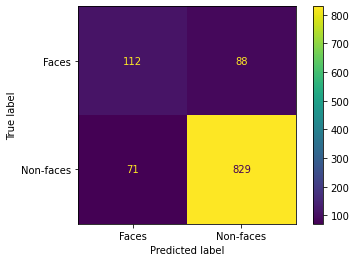

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       200
           1       0.90      0.92      0.91       900

    accuracy                           0.86      1100
   macro avg       0.76      0.74      0.75      1100
weighted avg       0.85      0.86      0.85      1100
 

neighbor   9 

Non faces :  2000


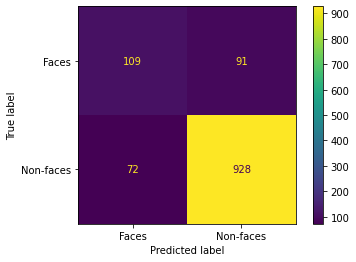

              precision    recall  f1-score   support

           0       0.60      0.55      0.57       200
           1       0.91      0.93      0.92      1000

    accuracy                           0.86      1200
   macro avg       0.76      0.74      0.75      1200
weighted avg       0.86      0.86      0.86      1200
 

neighbor   5 



In [ ]:
for i in range(1000, 2200, 200):
  print("Non faces : ", i)
  labels_training, labels_testing, data_training , data_testing = get_train_test(data_matrix, data_matrix_non_faces,i)
  # getting number of eigen vectors
  instances_per_classes = np.array([200, i//2])
  # momkn a7ot el line da gowa el get num of eigen vectors bs lma at2kd anha sh8ala
  eigen_values_i, eigen_vectors_i = LDA_Eigen(2 , instances_per_classes, data_training)
  projected_faces_train, projected_faces_test = LDA_Projected(data_training, data_testing, eigen_values_i, eigen_vectors_i, 1)
  best_accuracy_i , best_k_i, best_pred = knn(projected_faces_train, labels_training, projected_faces_test, labels_testing)
  confusion_matrix = metrics.confusion_matrix(labels_testing, best_pred)
  plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Faces','Non-faces'])
  plot.plot()
  plt.show()
  print(metrics.classification_report(labels_testing, best_pred),"\n")
  print("neighbor  ",best_k_i,"\n")

Non faces :  50


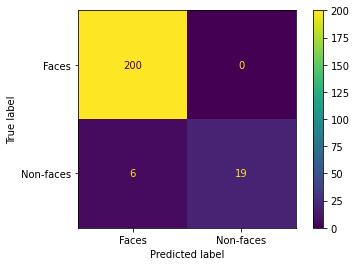

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       200
           1       1.00      0.76      0.86        25

    accuracy                           0.97       225
   macro avg       0.99      0.88      0.92       225
weighted avg       0.97      0.97      0.97       225
 

neighbor   3 

Non faces :  100


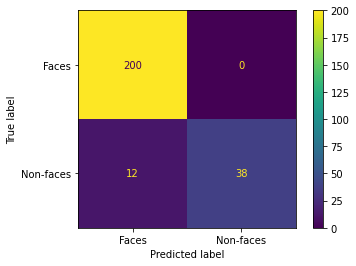

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       200
           1       1.00      0.76      0.86        50

    accuracy                           0.95       250
   macro avg       0.97      0.88      0.92       250
weighted avg       0.95      0.95      0.95       250
 

neighbor   3 

Non faces :  150


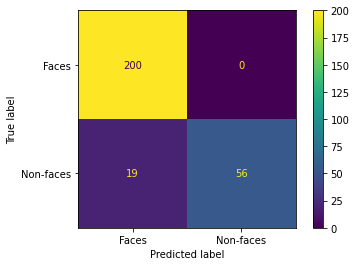

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       200
           1       1.00      0.75      0.85        75

    accuracy                           0.93       275
   macro avg       0.96      0.87      0.90       275
weighted avg       0.94      0.93      0.93       275
 

neighbor   9 

Non faces :  200


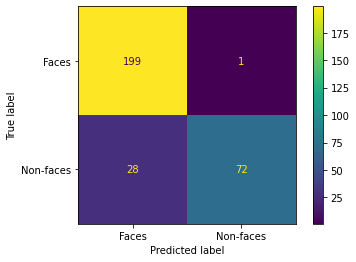

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       200
           1       0.99      0.72      0.83       100

    accuracy                           0.90       300
   macro avg       0.93      0.86      0.88       300
weighted avg       0.91      0.90      0.90       300
 

neighbor   13 



In [ ]:
for i in range(50, 250, 50):
  print("Non faces : ", i)
  labels_training, labels_testing, data_training , data_testing = get_train_test(data_matrix, data_matrix_non_faces,i)
  # getting number of eigen vectors
  instances_per_classes = np.array([200, i//2])
  # momkn a7ot el line da gowa el get num of eigen vectors bs lma at2kd anha sh8ala
  eigen_values_i, eigen_vectors_i = LDA_Eigen(2 , instances_per_classes, data_training)
  projected_faces_train, projected_faces_test = LDA_Projected(data_training, data_testing, eigen_values_i, eigen_vectors_i, 1)
  best_accuracy_i , best_k_i, best_pred = knn(projected_faces_train, labels_training, projected_faces_test, labels_testing)
  confusion_matrix = metrics.confusion_matrix(labels_testing, best_pred)
  plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Faces','Non-faces'])
  plot.plot()
  plt.show()
  print(metrics.classification_report(labels_testing, best_pred),"\n")
  print("neighbor  ",best_k_i,"\n")

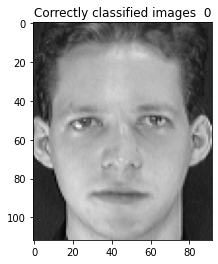

classified as  Face 



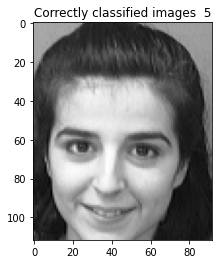

classified as  Face 



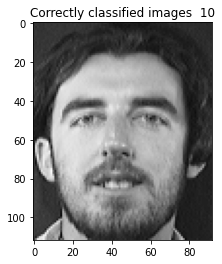

classified as  Face 



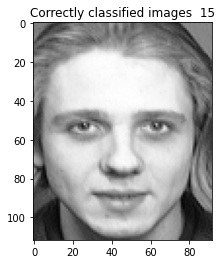

classified as  Face 



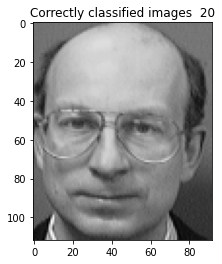

classified as  Face 



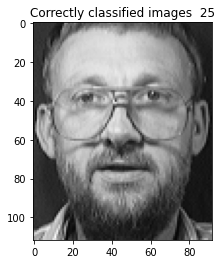

classified as  Face 



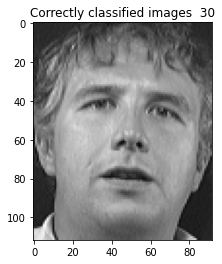

classified as  Face 



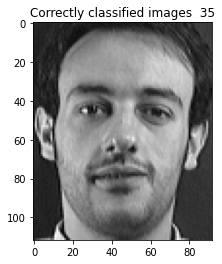

classified as  Face 



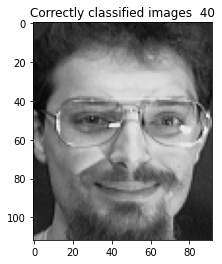

classified as  Face 



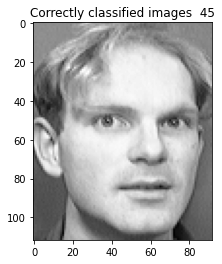

classified as  Face 



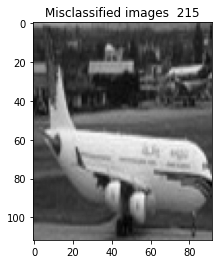

classified as  Face 



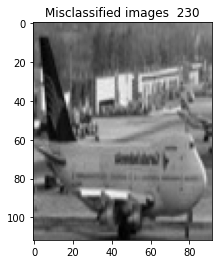

classified as  Face 



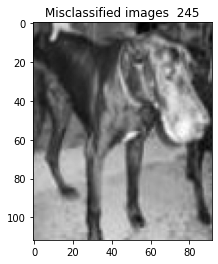

classified as  Face 



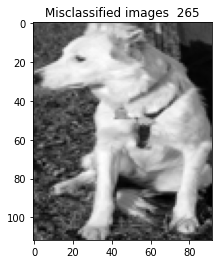

classified as  Face 



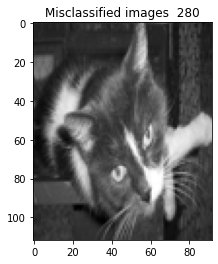

classified as  Face 



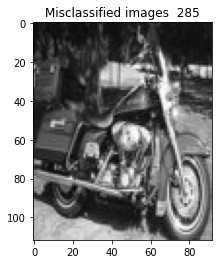

classified as  Face 



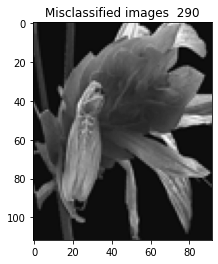

classified as  Face 

10
7


In [ ]:
# Success and failure cases
labels_train_200, labels_test_200, data_train_200 , data_test_200 = get_train_test(data_matrix, data_matrix_non_faces,200)
instances_per_classes_200 = np.array([200, 100])
eigen_values_200, eigen_vectors_200 = LDA_Eigen(2 , instances_per_classes_200, data_train_200)
projected_faces_train, projected_faces_test = LDA_Projected(data_train_200, data_test_200, eigen_values_200, eigen_vectors_200, 1)
best_accuracy_i , best_k_i, labels_pred_200 = knn(projected_faces_train, labels_train_200, projected_faces_test, labels_test_200)
# projected_train_200, projected_test_200 = LDA_Projected(data_train_200, data_test_200, eigen_values_200, eigen_vectors_200, number_vectors)
# knn_model = KNeighborsClassifier(n_neighbors = best_k_200)
# knn_model.fit(projected_train_200, labels_train_200)
# # Predict Output
# labels_pred_200 = knn_model.predict(projected_test_200)

classified_misclassified(data_test_200, labels_test_200, labels_pred_200)

# **Testing accuracies vs number of Non faces Using PCA**

In [ ]:
for i in range(200, 1000,200):
    labels_training, labels_testing, data_training , data_testing = get_train_test(data_matrix, data_matrix_non_faces,i)
    print("Accuracies for ",i," Non-Faces : ")
    pca(data_training, data_testing, labels_training, labels_testing)

Alpha =  0.8
number of eigen values taken :  38
Best n-neighbours:  1
K-NN Accuracy:  0.92 

Alpha =  0.85
number of eigen values taken :  56
Best n-neighbours:  1
K-NN Accuracy:  0.9166666666666666 

Alpha =  0.9
number of eigen values taken :  84
Best n-neighbours:  1
K-NN Accuracy:  0.9066666666666666 

Alpha =  0.95
number of eigen values taken :  136
Best n-neighbours:  1
K-NN Accuracy:  0.8966666666666666 

Alpha =  0.8
number of eigen values taken :  43
Best n-neighbours:  1
K-NN Accuracy:  0.905 

Alpha =  0.85
number of eigen values taken :  64
Best n-neighbours:  1
K-NN Accuracy:  0.89 

Alpha =  0.9
number of eigen values taken :  100
Best n-neighbours:  1
K-NN Accuracy:  0.8875 

Alpha =  0.95
number of eigen values taken :  167
Best n-neighbours:  1
K-NN Accuracy:  0.8625 

Alpha =  0.8
number of eigen values taken :  47
Best n-neighbours:  1
K-NN Accuracy:  0.9 

Alpha =  0.85
number of eigen values taken :  73
Best n-neighbours:  1
K-NN Accuracy:  0.888 

Alpha =  0.9
nu